# SVD on Images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageOps
from numpy.linalg import svd, matrix_rank

In [2]:
from ipywidgets import interact,interactive,interact_manual

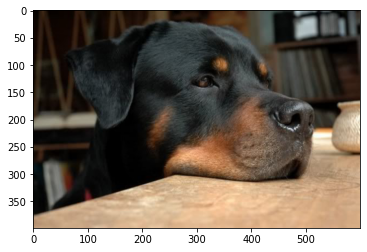

In [3]:
# read the image file and print it
filename = 'rgb-dog.jpg'
img = Image.open('data/'+filename)
# img = img.resize((640,320))
plt.imshow(np.asarray(img))
plt.show()

rank of the image matrix: 399



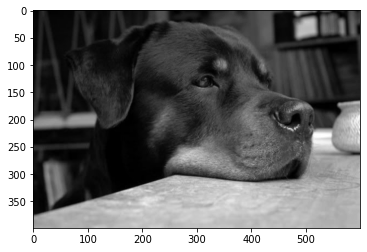

In [4]:
# convert image to grayscale
gray_img = ImageOps.grayscale(img)
gray_img.save('data/output/gray-original.png')
rank = matrix_rank(gray_img)
print(f'rank of the image matrix: {rank}')
print()
plt.imshow(np.asarray(gray_img), cmap='gray')
plt.show()

In [5]:
# The image matrix
img_mat = np.array(gray_img)
print(f'image shape: {img_mat.shape}')
print()
print('image matrix: ')
print(img_mat)

image shape: (399, 600)

image matrix: 
[[  6   5   6 ...  30  35  37]
 [  6   5   6 ...  33  37  39]
 [  6   6   6 ...  37  40  42]
 ...
 [158 158 159 ... 182 182 182]
 [160 160 161 ... 182 182 182]
 [161 162 162 ... 182 182 182]]


In [6]:
# Perform singular value decomposition
U, s, V = svd(gray_img)

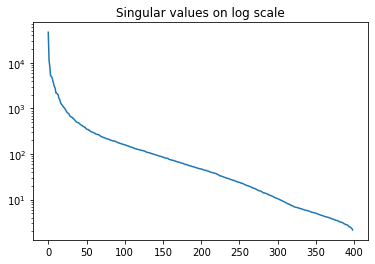

In [7]:
plt.plot(s)
plt.yscale('log')
plt.title('Singular values on log scale')
plt.show()

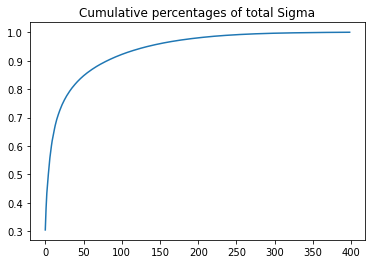

In [8]:
plt.plot(np.cumsum(s) / np.sum(s))
plt.title('Cumulative percentages of total Sigma')
plt.show()

In [9]:
def calculate_optimal_k(singular_values, rank):
    """method to calculate the optimal k"""
    heuristic_k = 0.15 * rank
    optimal_k = heuristic_k
    end_idx = len(singular_values) - 10
    for idx in range(0, end_idx):
        sig_diff = max(singular_values[idx:idx + 10]) - min(singular_values[idx:idx + 10])
        if sig_diff < 0.32:
            optimal_k = idx
            break
    return min(heuristic_k, optimal_k)

optimal_k = calculate_optimal_k(s, rank)
optimal_k = round(optimal_k)
print(f'optimal reduced dimension k value: {optimal_k}')

optimal reduced dimension k value: 60


In [10]:
def percentage_of_info_restored(k, sigma_matrix):
    """calculate percentage of information restored. Measured as sum of singular values
    retained in the optimal_k dimensions divided by total sum of singular values."""
    sum_sigma = 0
    sum_k_sigma = 0
    sum_sigma += np.trace(sigma_matrix)
    stripped_sigma_matrix = sigma_matrix[:k, :k]
    sum_k_sigma += np.trace(stripped_sigma_matrix)
    return (sum_k_sigma/sum_sigma)*100

s_diag = np.diag(s)
per_info = percentage_of_info_restored(optimal_k, s_diag)

print(f'percentage of information retained: {per_info}')

percentage of information retained: 86.55341500378796


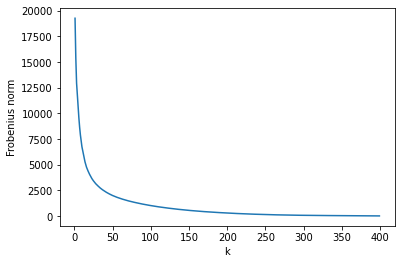

In [11]:
def calculate_frobenius_norm(k, channel, u, s_diagonalized, vt):
    u_k = u[:, :k]
    s_diagonalized_k = s_diagonalized[:k, :k]
    vt_k = vt[:k, :]
    channel_reconstruction_matrix = np.dot(np.dot(u_k, s_diagonalized_k), vt_k)
    rec_error_matrix = np.subtract(channel, channel_reconstruction_matrix)
    frobenius_norm = np.linalg.norm(rec_error_matrix, 'fro')
    return frobenius_norm

def calculate_frobenius_norm_all_k(channel, u, s_diagonalized, vt):
    """
    method to calculate the frobenius norm of the reconstructed matrix
    Done by taking 1 to k (k=rank of the channel) components in the reconstruction process.
    :return: list of frobenius norms calculated by the first k signular values of the matrix
    """
    rank_channel = np.linalg.matrix_rank(channel)
    frobenius_norm_array = np.zeros(rank_channel)
    for k in range(1, rank_channel+1):
        u_k = u[:, :k]
        s_diagonalized_k = s_diagonalized[:k, :k]
        vt_k = vt[:k, :]
        channel_reconstruction_matrix = np.dot(np.dot(u_k, s_diagonalized_k), vt_k)
        rec_error_matrix = np.subtract(channel, channel_reconstruction_matrix)
        frobenius_norm = np.linalg.norm(rec_error_matrix, 'fro')
        frobenius_norm_array[k-1] = frobenius_norm
    return frobenius_norm_array

def plot_frobenius_norm(frobenius_norm, rank):
    """Plot the frobenius norm of the three channels on for analysis"""
    x = np.arange(1, rank+1)
    plt.xlabel('k')
    plt.ylabel('Frobenius norm')
    plt.plot(x, frobenius_norm)
    plt.show()
    
frobenius_norm = calculate_frobenius_norm_all_k(gray_img, U, s_diag, V)
plot_frobenius_norm(frobenius_norm, rank)

frobenius_norm: 1704.9647949160922


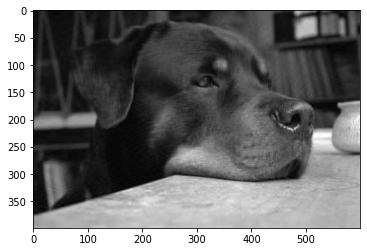

In [12]:
def reconstruct_matrix(k, u, s_diagonalized, vt):
    """reconstructs a matrix by selecting optimal_k signular values"""
    channel_u_k = u[:, :k]
    channel_s_diagonal_k = s_diagonalized[:k, :k]
    channel_vt_k = vt[:k, :]
    channel_reconstruction_matrix = np.dot(np.dot(channel_u_k, channel_s_diagonal_k), channel_vt_k)
    channel_reconstruction_matrix = 255 * channel_reconstruction_matrix
    return channel_reconstruction_matrix

reconstruction_matrix = reconstruct_matrix(optimal_k, U, s_diag, V)
frobenius_norm = calculate_frobenius_norm(optimal_k, gray_img, U, s_diag, V)
print(f'frobenius_norm: {frobenius_norm}')
plt.imshow(reconstruction_matrix, cmap='gray')
plt.show()
plt.imsave('data/output/gray-optimal.png', reconstruction_matrix, cmap='gray')

frobenius_norm: 1704.9647949160922


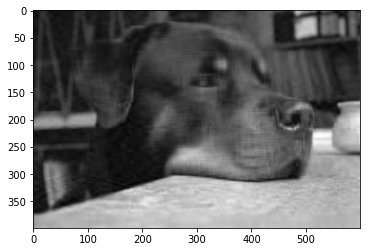

In [15]:
test_k = 30

reconstruction_matrix = reconstruct_matrix(test_k, U, s_diag, V)
frobenius_norm = calculate_frobenius_norm(optimal_k, gray_img, U, s_diag, V)
print(f'frobenius_norm: {frobenius_norm}')
plt.imshow(reconstruction_matrix, cmap='gray')
plt.show()
plt.imsave(f'data/output/gray-k{test_k}.png', reconstruction_matrix, cmap='gray')